In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Merge transactions with customers and products
data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

In [14]:
data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 8:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22,SoundWave Smartwatch,Electronics,459.86
996,T00759,C0059,P037,2024-06-04 2:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07,SoundWave Smartwatch,Electronics,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21,SoundWave Smartwatch,Electronics,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11,SoundWave Smartwatch,Electronics,459.86


C:\Users\chint\AppData\Local\Temp\ipykernel_12264\1940059594.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features['Price_std'].fillna(0, inplace=True)
C:\Users\chint\AppData\Local\Temp\ipykernel_12264\1940059594.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Customer Segments (Clusters):
    CustomerID  Cluster
0        C0001        1
1        C0002        2
2        C0003        1
3        C0004        0
4        C0005        4
..         ...      ...
194      C0196        3
195      C0197        4
196      C0198        2
197      C0199        4
198      C0200        2

[199 rows x 2 columns]


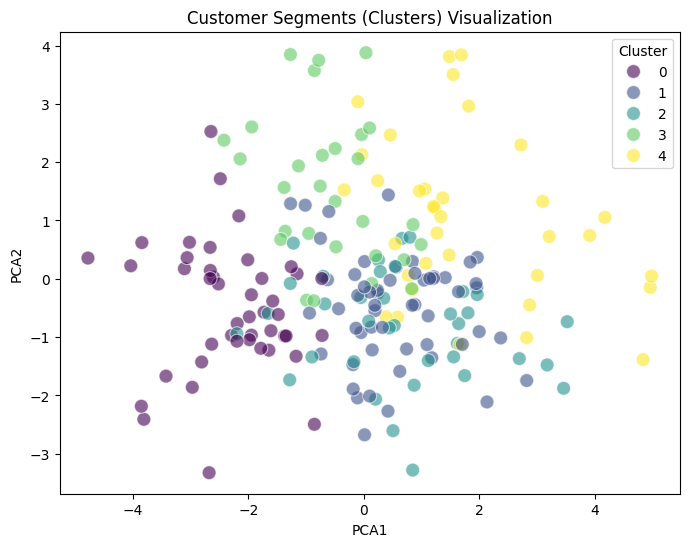

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



# Feature Engineering
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean'],
    'Price_x': ['mean', 'std'],
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'  # Most frequent category
}).reset_index()

# Flatten the multi-level columns
customer_features.columns = ['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 'Transaction_count', 
                             'Quantity_sum', 'Quantity_mean', 'Price_mean', 'Price_std', 'Favorite_Category']

# Merge with customer information
customer_features = pd.merge(customer_features, customers, on='CustomerID')

# Handle missing values in numerical columns (replace NaN with 0 or mean)
customer_features['Price_std'].fillna(0, inplace=True)
customer_features['Price_mean'].fillna(customer_features['Price_mean'].mean(), inplace=True)

# Encode categorical variables
customer_features = pd.get_dummies(customer_features, columns=['Region', 'Favorite_Category'])

# Normalize the features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# Display the cluster labels for each customer
print("Customer Segments (Clusters):")
print(customer_features[['CustomerID', 'Cluster']])

# Visualize the clusters using PCA (2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features_scaled)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_features['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6)
plt.title("Customer Segments (Clusters) Visualization")
plt.show()

# Optionally, save the customer data with clusters to a CSV file
customer_with_clusters_csv = customer_features.to_csv(index=False)
with open('Customer_Clusters.csv', 'w') as f:
    f.write(customer_with_clusters_csv)


In [24]:
customer_features[['CustomerID', 'CustomerName', 'TotalValue_mean', 'Transaction_count', 'Quantity_mean', 'Price_mean',
       'Cluster']]

,CustomerID,CustomerName,TotalValue_mean,Transaction_count,Quantity_mean,Price_mean,Cluster
0,C0001,Lawrence Carroll,670.904000,5,2.400000,278.334000,1
1,C0002,Elizabeth Lutz,465.685000,4,2.500000,208.920000,5
2,C0003,Michael Rivera,681.345000,4,3.500000,195.707500,1
3,C0004,Kathleen Rodriguez,669.360000,8,2.875000,240.636250,0
4,C0005,Laura Weber,678.080000,3,2.333333,291.603333,4
...,...,...,...,...,...,...,...
194,C0196,Laura Watts,1245.720000,4,3.000000,416.992500,3
195,C0197,Christina Harvey,642.883333,3,3.000000,227.056667,3
196,C0198,Rebecca Ray,465.915000,2,1.500000,239.705000,5
197,C0199,Andrea Jenkins,494.820000,4,2.250000,250.610000,3


In [21]:
customer_features.columns

Index(['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 'Transaction_count',
       'Quantity_sum', 'Quantity_mean', 'Price_mean', 'Price_std',
       'CustomerName', 'SignupDate', 'Region_Asia', 'Region_Europe',
       'Region_North America', 'Region_South America',
       'Favorite_Category_Books', 'Favorite_Category_Clothing',
       'Favorite_Category_Electronics', 'Favorite_Category_Home Decor',
       'Cluster'],
      dtype='object')

Interpreting DBI:
Lower DBI values indicate better clustering. It suggests that clusters are compact and well-separated.



Higher DBI values indicate poor clustering, meaning the clusters are either too spread out or too close together.

Davies-Bouldin Index: 2.2264


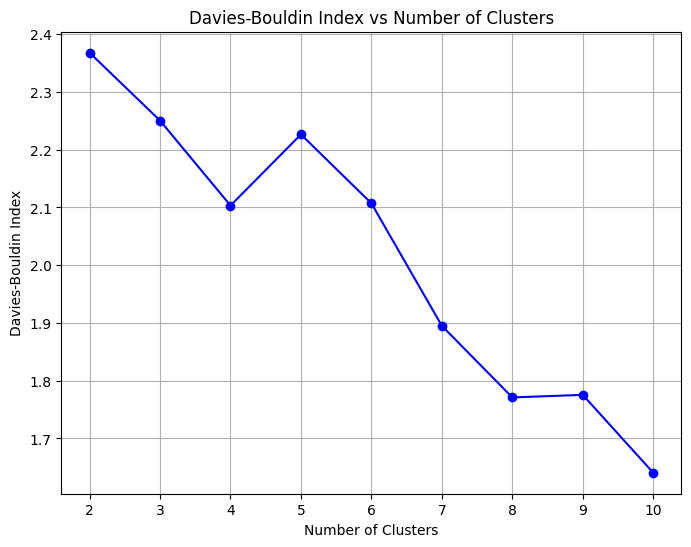

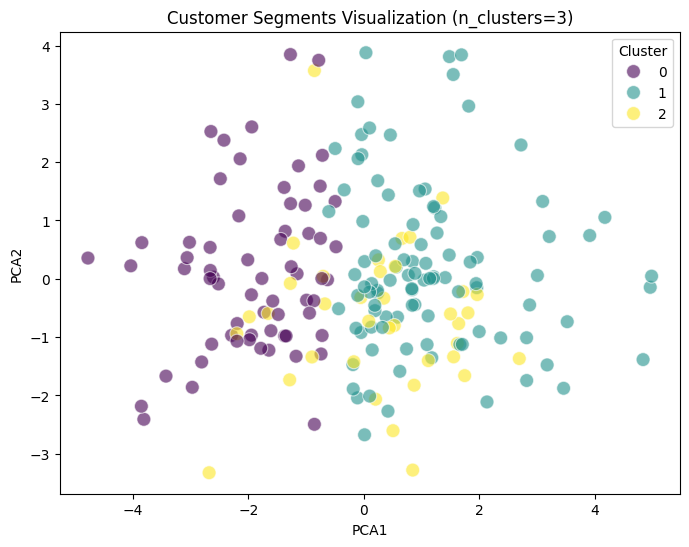

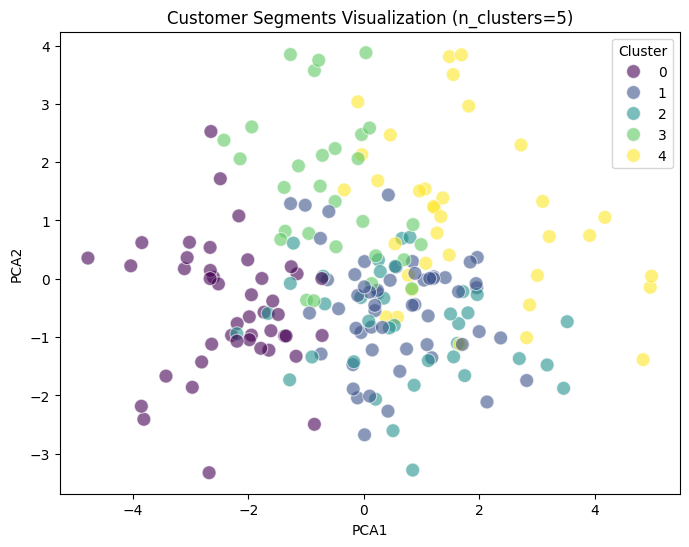

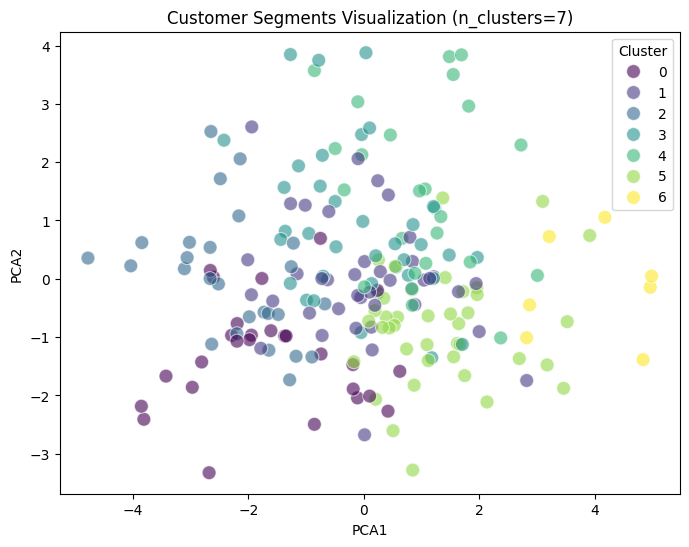

In [19]:
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Try different numbers of clusters (between 2 and 10) and calculate the DB Index for each
db_indexes = []
n_clusters_range = range(2, 11)
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(customer_features_scaled)
    db_index = davies_bouldin_score(customer_features_scaled, clusters)
    db_indexes.append(db_index)

# Plot DB Index vs Number of Clusters to help determine the best number of clusters
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, db_indexes, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

# Optionally, visualizing clusters for different number of clusters
for n_clusters in [3, 5, 7]:  # Adjust the numbers you want to visualize
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

    # Apply PCA for 2D visualization
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(customer_features_scaled)

    pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = customer_features['Cluster']

    # Plot the clusters for the current n_clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6)
    plt.title(f"Customer Segments Visualization (n_clusters={n_clusters})")
    plt.show()


Best Result - 10 Clusters --> Lowest DBI Score

C:\Users\chint\AppData\Local\Temp\ipykernel_12264\1125824350.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features['Price_std'].fillna(0, inplace=True)
C:\Users\chint\AppData\Local\Temp\ipykernel_12264\1125824350.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Customer Segments (Clusters):
    CustomerID  Cluster
0        C0001        6
1        C0002        3
2        C0003        2
3        C0004        0
4        C0005        3
..         ...      ...
194      C0196        2
195      C0197        9
196      C0198        4
197      C0199        9
198      C0200        5

[199 rows x 2 columns]


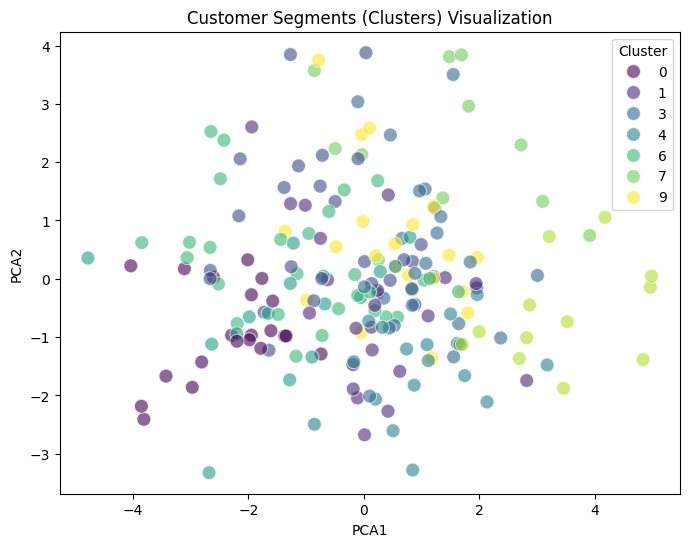

In [26]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



# Feature Engineering
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean'],
    'Price_x': ['mean', 'std'],
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'  # Most frequent category
}).reset_index()

# Flatten the multi-level columns
customer_features.columns = ['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 'Transaction_count', 
                             'Quantity_sum', 'Quantity_mean', 'Price_mean', 'Price_std', 'Favorite_Category']

# Merge with customer information
customer_features = pd.merge(customer_features, customers, on='CustomerID')

# Handle missing values in numerical columns (replace NaN with 0 or mean)
customer_features['Price_std'].fillna(0, inplace=True)
customer_features['Price_mean'].fillna(customer_features['Price_mean'].mean(), inplace=True)

# Encode categorical variables
customer_features = pd.get_dummies(customer_features, columns=['Region', 'Favorite_Category'])

# Normalize the features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust the number of clusters as needed
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# Display the cluster labels for each customer
print("Customer Segments (Clusters):")
print(customer_features[['CustomerID', 'Cluster']])

# Visualize the clusters using PCA (2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features_scaled)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_features['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6)
plt.title("Customer Segments (Clusters) Visualization")
plt.show()

# Optionally, save the customer data with clusters to a CSV file
customer_with_clusters_csv = customer_features.to_csv(index=False)
with open('Customer_Clusters.csv', 'w') as f:
    f.write(customer_with_clusters_csv)


Davies-Bouldin Index: 1.6406


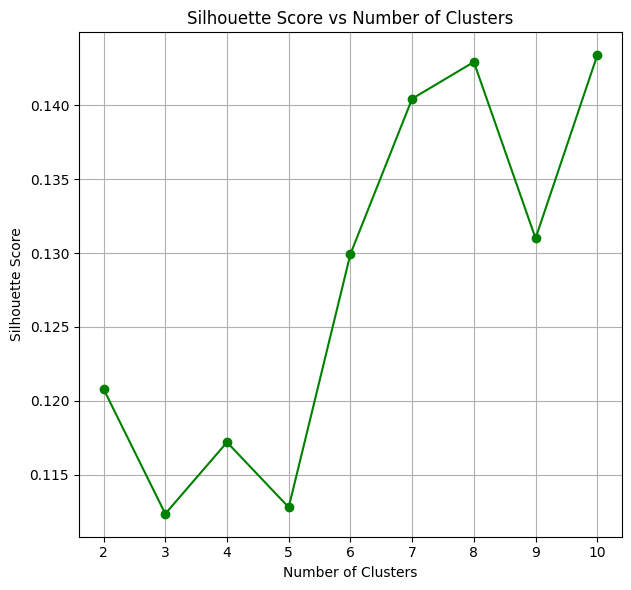

In [27]:
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Davies-Bouldin Index calculation
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Try different numbers of clusters (between 2 and 10) and calculate the DB Index and Silhouette Score for each
db_indexes = []
silhouette_scores = []
n_clusters_range = range(2, 11)
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(customer_features_scaled)
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_features_scaled, clusters)
    db_indexes.append(db_index)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(customer_features_scaled, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot DB Index and Silhouette Score vs Number of Clusters
plt.figure(figsize=(12, 6))



# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()
